## Mask R-CNN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [2]:
import os
import sys

import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import yaml
import logging
import logging.config
from easydict import EasyDict as edict

AI_CODE_BASE_PATH = '/codehub'
BASE_PATH_CONFIG = os.path.join(AI_CODE_BASE_PATH,'config')
APP_ROOT_DIR = os.path.join(AI_CODE_BASE_PATH,'apps')

if APP_ROOT_DIR not in sys.path:
  sys.path.insert(0, APP_ROOT_DIR)

import _cfg_
from falcon.arch import Model
import apputil
import viz

from _log_ import logcfg
log = logging.getLogger(__name__)
logging.config.dictConfig(logcfg)

appcfg = _cfg_.load_appcfg(BASE_PATH_CONFIG)
appcfg = edict(appcfg)

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
# from mrcnn.model import log

%matplotlib inline 

2020-01-08 20:14:55,599:[DEBUG]:[__main__._cfg_]:[_cfg_.py:188 -          load_appcfg() ]: appcfg: {'PATHS': {'AI_AIDS_DB': '/aimldl-dat/data-gaze/AIML_Aids', 'AI_ANNON_DATA_HOME': '/data/samba/Bangalore/prod/Bangalore_Maze_Exported_Data/ANNOTATIONS', 'AI_ANNON_DATA_HOME_LOCAL': '/aimldl-dat/data-gaze/AIML_Annotation/ods_merged_on_281219_125647', 'AI_ANNON_DB': '/aimldl-dat/data-gaze/AIML_Database', 'AI_ANNON_HOME': '/codehub/apps/annon', 'AI_APP': '/codehub/apps', 'AI_CFG': '/codehub/cfg', 'AI_CONFIG': '/codehub/config', 'AI_DATA': '/aimldl-dat', 'AI_DATA_GAZE': '/aimldl-dat/data-gaze', 'AI_DOC': '/aimldl-doc', 'AI_GOOGLE_APPLICATION_CREDENTIALS': '/codehub/auth/', 'AI_HOME': '/codehub', 'AI_HOME_EXT': '/codehub/external', 'AI_KBANK': '/aimldl-kbank', 'AI_LANENET_ROOT': '/codehub/external/lanenet-lane-detection', 'AI_LOGS': '/aimldl-dat/logs', 'AI_MNT': '/aimldl-mnt', 'AI_MODEL_CFG_PATH': '/codehub/cfg/model', 'AI_PYVER': '3', 'AI_PY_ENVVARS': 'AI_APP:AI_HOME_EXT:MASK_RCNN:FASTER_RCNN

In [3]:
def get_modelcfg(cfg, modelinfo_filepath):
    modelcfg = _cfg_.load_yaml(modelinfo_filepath)
    if type(modelcfg) != type([]):
        ## quick fix for name not present in config
        if modelcfg and modelcfg['config']:
            if 'name' in modelcfg:
                modelcfg['config']['NAME'] = modelcfg['name']
            if 'num_classes' in modelcfg:
                modelcfg['config']['NUM_CLASSES'] = modelcfg['num_classes']
            
            weights_path = apputil.get_abs_path(cfg, modelcfg, 'AI_WEIGHTS_PATH')
            modelcfg['weights_path'] = weights_path

    return modelcfg


def load_model(cfg, modelinfo_filepath):
    modelcfg = get_modelcfg(cfg, modelinfo_filepath)
    log.debug("modelcfg: {}".format(modelcfg))

    if modelcfg:
        mode = modelcfg['mode']
        dnnarch = modelcfg['dnnarch']
        dnnmod = apputil.get_module(dnnarch)
        load_model_and_weights = apputil.get_module_fn(dnnmod, "load_model_and_weights")
        
#         modelcfg['log_dir'] = log_dir
        log_dir_path = apputil.get_abs_path(cfg, modelcfg, 'AI_LOGS')
        weights_path = apputil.get_abs_path(cfg, modelcfg, 'AI_WEIGHTS_PATH')
        modelcfg['log_dir_path'] = log_dir_path
        modelcfg['weights_path'] = weights_path

        model = load_model_and_weights(mode, modelcfg, cfg)
        print("model: {}".format(model))
    return model


In [4]:
MODELINFO_FILEPATH = '/codehub/cfg/model/release/vidteq-ods-7-mask_rcnn.yml'
HOST = "10.4.71.69"
AI_ANNON_DATA_HOME_LOCAL ="/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119"

cmd = "train"
dbname = "PXL-291119_180404"
exp_id = "train-422d30b0-f518-4203-9c4d-b36bd8796c62"
subset = "val"

eval_on = subset

## Load Configurations

In [5]:
appcfg['APP']['DBCFG']['PXLCFG']['host'] = HOST
appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'] = AI_ANNON_DATA_HOME_LOCAL

# log.debug(appcfg)
# log.info(appcfg['APP']['DBCFG']['PXLCFG'])
# log.info(appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'])

In [6]:
## datacfg and dbcfg
_cfg_.load_datacfg(cmd, appcfg, dbname, exp_id, eval_on)
datacfg = apputil.get_datacfg(appcfg)
dbcfg = apputil.get_dbcfg(appcfg)

# log.info("datacfg: {}".format(datacfg))
# log.info("dbcfg: {}".format(dbcfg))

2020-01-08 20:15:05,604:[DEBUG]:[__main__._cfg_]:[_cfg_.py:65 -         load_datacfg() ]: ----------------------------->
2020-01-08 20:15:05,606:[DEBUG]:[__main__._cfg_]:[_cfg_.py:66 -         load_datacfg() ]: cmd, appcfg, dbname, exp_id, eval_on:  train, {'PATHS': {'AI_AIDS_DB': '/aimldl-dat/data-gaze/AIML_Aids', 'AI_ANNON_DATA_HOME': '/data/samba/Bangalore/prod/Bangalore_Maze_Exported_Data/ANNOTATIONS', 'AI_ANNON_DATA_HOME_LOCAL': '/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119', 'AI_ANNON_DB': '/aimldl-dat/data-gaze/AIML_Database', 'AI_ANNON_HOME': '/codehub/apps/annon', 'AI_APP': '/codehub/apps', 'AI_CFG': '/codehub/cfg', 'AI_CONFIG': '/codehub/config', 'AI_DATA': '/aimldl-dat', 'AI_DATA_GAZE': '/aimldl-dat/data-gaze', 'AI_DOC': '/aimldl-doc', 'AI_GOOGLE_APPLICATION_CREDENTIALS': '/codehub/auth/', 'AI_HOME': '/codehub', 'AI_HOME_EXT': '/codehub/external', 'AI_KBANK': '/aimldl-kbank', 'AI_LANENET_ROOT': '/codehub/external/lanenet-lane-detection', 'AI_LOGS': '/aimldl-dat/logs'

In [8]:
## archcfg, cmdcfg

_cfg_.load_archcfg(cmd, appcfg, dbname, exp_id, eval_on)
archcfg = apputil.get_archcfg(appcfg)
# log.debug("archcfg: {}".format(archcfg))
cmdcfg = archcfg

2020-01-08 20:15:24,371:[DEBUG]:[__main__._cfg_]:[_cfg_.py:119 -         load_archcfg() ]: ----------------------------->
2020-01-08 20:15:24,374:[DEBUG]:[__main__._cfg_]:[_cfg_.py:150 -         load_archcfg() ]: DBCFG: {'ANNONCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'annon_v11', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'CBIRCFG': {'dbname': 'eka', 'host': '10.4.71.69', 'password': '', 'port': 27017, 'username': ''}, 'OASISCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'oasis', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'PXLCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'ret

## Notebook Preferences

In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [10]:
model = load_model(appcfg, MODELINFO_FILEPATH)
model.keras_model.layers

2020-01-08 20:15:30,626:[DEBUG]:[__main__]:[<ipython-input-3-62d2d59774d7>:19 -           load_model() ]: modelcfg: {'checkpoint_path': '/aimldl-dat/logs/mask_rcnn/281119_154803/train_hmd_031219_071805/mask_rcnn_hmd_{epoch:04d}.h5', 'classes': ['BG', 'signage', 'traffic_light', 'traffic_sign'], 'classinfo': None, 'config': {'DETECTION_MIN_CONFIDENCE': 0.9, 'GPU_COUNT': 1, 'IMAGES_PER_GPU': 1, 'IMAGE_MAX_DIM': 1280, 'IMAGE_MIN_DIM': 720, 'STEPS_PER_EPOCH': 1000, 'NAME': 'hmd', 'NUM_CLASSES': 4}, 'creator': 'AIE1', 'dataset': 'PXL-281119_154739', 'dbname': 'PXL-281119_154739', 'dnnarch': 'mask_rcnn', 'framework_type': 'keras', 'id': None, 'load_weights': {'by_name': True, 'exclude': ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask']}, 'log_dir': '/aimldl-dat/logs/mask_rcnn/281119_154803/train_hmd_031219_071805', 'mode': 'inference', 'model_info': 'vidteq-hmd-031219_071805-mask_rcnn.yml', 'name': 'hmd', 'num_classes': 4, 'org_name': 'vidteq', 'problem_id': 'ods', 'rel_num

2020-01-08 20:15:30,674:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: POST_NMS_ROIS_INFERENCE: 1000
2020-01-08 20:15:30,675:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: POST_NMS_ROIS_TRAINING: 2000
2020-01-08 20:15:30,676:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: PRE_NMS_LIMIT: 6000
2020-01-08 20:15:30,677:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: ROI_POSITIVE_RATIO: 0.33
2020-01-08 20:15:30,678:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_RATIOS: [0.5, 1, 2]
2020-01-08 20:15:30,679:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_SCALES: (32, 64, 128, 256, 512)
2020-01-08 20:15:30,680:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_ANCHOR_STRIDE: 1
2020-01-08 20:15:30,681:[DEBUG]:[__main__.mrcnn.model]:[model.py:1883 -             __init__() ]: RPN_BBOX_STD_DEV:

2020-01-08 20:15:30,755:[WARNING]:[tensorflow]:[deprecation.py:323 -             new_func() ]: From /virtualmachines/virtualenvs/py_3_20191211_1656/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2020-01-08 20:15:34,483:[DEBUG]:[__main__.mrcnn.model]:[model.py:2006 -                build() ]: output_names, outputs: ['rpn_class_logits', 'rpn_class', 'rpn_bbox'], [<tf.Tensor 'rpn_class_logits/concat:0' shape=(?, ?, 2) dtype=float32>, <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>, <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>]
Instructions for updating:
Use tf.cast instead.
2020-01-08 20:15:35,080:[WARNING]:[tensorflow]:[deprecation.py:323 -             new_func() ]: From /codehub/external/Mask_RCNN/mrcnn/model.py:809: to_float (from tensorflow.pyth

## Review Weight Stats

In [11]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


# Histograms of Weights

TODO: cleanup this part

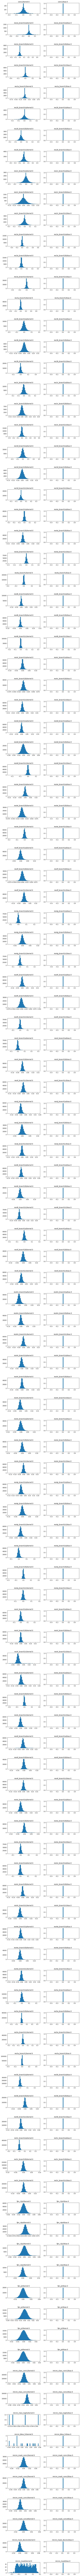

In [12]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
